In [1]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd

In [2]:
# **Loading Dataset**
data_train = np.load("C:/Users/PALLAVI/Downloads/train.npz", allow_pickle=True)
x_train = data_train['images']  
y_train = data_train['labels'] 
print(data_train.files)
print(x_train.shape)
print(y_train.shape)

['images', 'labels']
(72, 224, 224, 3)
(72,)


In [3]:

data_test = np.load("C:/Users/PALLAVI/Downloads/test.npz", allow_pickle=True)
x_test = data_test['images']    
y_test = data_test['labels']   

print(x_test.shape)
print(y_test.shape)

(30, 224, 224, 3)
(30,)


In [4]:
#DATA AUGMENTATION
train_data_generator = ImageDataGenerator(rotation_range=5,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
#                                     brightness_range=[0.5, 1.5],
                                    horizontal_flip=True,
                                    vertical_flip=True)

x = list(x_train)
y = list(y_train)

x_aug_train = []
y_aug_train = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = train_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(70):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_train.append(aug_image)
        y_aug_train.append(v)
print(len(x_aug_train))
print(len(y_aug_train))

x_train = x + x_aug_train
y_train = y + y_aug_train
print(len(x_train))
print(len(y_train))

test_data_generator = ImageDataGenerator(rotation_range=5,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
#                                     brightness_range=[0.5, 1.5],
                                    horizontal_flip=True,
                                    vertical_flip=True)

x = list(x_test)
y = list(y_test)

x_aug_test = []
y_aug_test = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = test_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(20):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_test.append(aug_image)
        y_aug_test.append(v)
print(len(x_aug_test))
print(len(y_aug_test))

x_test = x + x_aug_test
y_test = y + y_aug_test
print(len(x_test))
print(len(y_test))

5040
5040
5112
5112
600
600
630
630


In [5]:
for i in range(len(x_train)):
    img = x_train[i]
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_train[i] = img

for i in range(len(x_test)):
    img = x_test[i]
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_test[i] = img

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train/255.0
x_test = x_test/255.0

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
print(y_train.shape)

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
print(y_test.shape)

(5112,)
(630,)


In [6]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5112, 128, 128, 1)
(5112, 2)
(630, 128, 128, 1)
(630, 2)


In [7]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)


In [7]:
def parkinson_disease_detection_model(input_shape=(128, 128, 1)):
    regularizer = tf.keras.regularizers.l2(0.001)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(128, (5, 5), padding='same', strides=(1, 1), name='conv1', activation='relu',
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((9, 9), strides=(3, 3)))

    model.add(Conv2D(64, (5, 5), padding='same', strides=(1, 1), name='conv2', activation='relu',
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((7, 7), strides=(3, 3)))

    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu',
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((5, 5), strides=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu',
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((3, 3), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='relu', kernel_initializer='glorot_uniform', name='fc1'))
    model.add(Dropout(0.6))
    model.add(Dense(2, activation='softmax', kernel_initializer='glorot_uniform', name='fc3'))

    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model= parkinson_disease_detection_model(input_shape=(128, 128, 1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 128, 128, 128)  │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 40, 40, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 12, 12, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,146 (930.26 KB)

 Trainable params: 238,146 (930.26 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
hist = model.fit(x_train, y_train, batch_size=128, epochs=70, validation_data=(x_val, y_val))

Epoch 1/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.4976 - loss: 0.8597 - val_accuracy: 0.5048 - val_loss: 0.8482
Epoch 2/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 216s 5s/step - accuracy: 0.5095 - loss: 0.8477 - val_accuracy: 0.6476 - val_loss: 0.8416
Epoch 3/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 217s 5s/step - accuracy: 0.5220 - loss: 0.8406 - val_accuracy: 0.5619 - val_loss: 0.8353
Epoch 4/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.5360 - loss: 0.8324 - val_accuracy: 0.6381 - val_loss: 0.8291
Epoch 5/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.5432 - loss: 0.8257 - val_accuracy: 0.5873 - val_loss: 0.8228
Epoch 6/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 216s 5s/step - accuracy: 0.5364 - loss: 0.8199 - val_accuracy: 0.5889 - val_loss: 0.8168
Epoch 7/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.5550 - loss: 0.8126 - val_accuracy: 0.5540 - val_loss: 0.8115
Epoch 8/70
40/40 ━━━━━━━━━━━━━━━━━━━━ 215s 5s/step - accuracy: 0.5702 - loss: 0.8050 - val_accuracy: 0.5873 - v

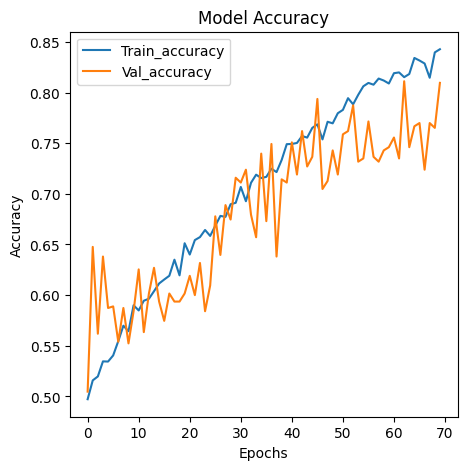

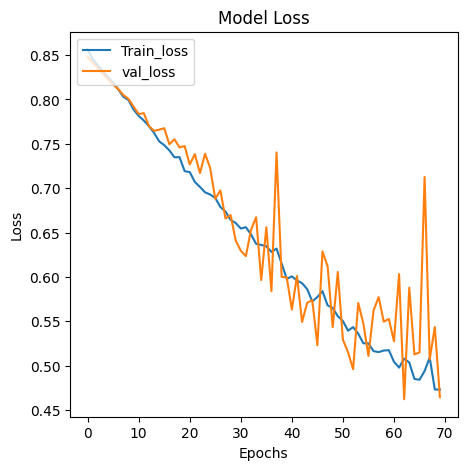

In [10]:
figure = plt.figure(figsize=(5, 5))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(5, 5))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [11]:
ypred = model.predict(x_test)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
print(classification_report(y_test_pred, ypred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 344ms/step
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       315
           1       0.85      0.75      0.80       315

    accuracy                           0.81       630
   macro avg       0.81      0.81      0.81       630
weighted avg       0.81      0.81      0.81       630



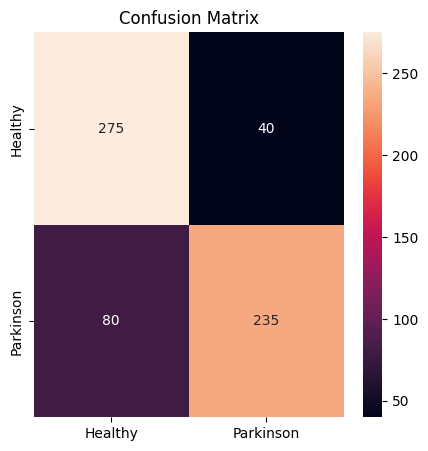

In [12]:
matrix = confusion_matrix(y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=['Healthy', 'Parkinson'], columns=['Healthy', 'Parkinson'])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [14]:


labels = ['Healthy', 'Parkinson']
image_healthy = cv2.imread("C:/Users/PALLAVI/OneDrive/Desktop/parkinson/wave/wave/testing/healthy/V03HO01.png")
image_parkinson = cv2.imread("C:/Users/PALLAVI/OneDrive/Desktop/parkinson/wave/wave/testing/parkinson/V09PO01.png")

image_healthy = np.array(image_healthy)
image_healthy = nimage_healthy = cv2.resize(image_healthy, (128, 128))
image_healthy = cv2.cvtColor(image_healthy, cv2.COLOR_BGR2GRAY)
image_healthy = np.expand_dims(image_healthy, axis=0) #adds batch dimension
image_healthy = np.expand_dims(image_healthy, axis=-1) #adds channel dimension

image_parkinson = cv2.resize(image_parkinson, (128, 128))
image_parkinson = cv2.cvtColor(image_parkinson, cv2.COLOR_BGR2GRAY)
image_parkinson = np.array(image_parkinson)
image_parkinson = np.expand_dims(image_parkinson, axis=0)
image_parkinson = np.expand_dims(image_parkinson, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


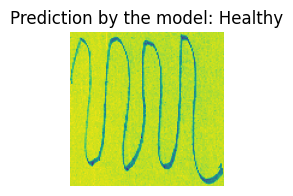

In [15]:

ypred_healthy = model.predict(image_healthy)
figure = plt.figure(figsize=(2, 2))
img_healthy = np.squeeze(image_healthy, axis=0) #Removes the batch dimension
plt.imshow(img_healthy)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_healthy[0], axis=0)]}')
plt.show()


In [ ]:
ypred_parkinson = model.predict(image_parkinson)
figure = plt.figure(figsize=(2, 2))
image_parkinson = np.squeeze(image_parkinson, axis=0)
plt.imshow(image_parkinson)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_parkinson[0], axis=0)]}')
plt.show()

In [18]:
model.save('cnnwav.h5')